# Using Python BeautifulSoup to scrape DataCamp Tutorials & Analyze
[Source](https://www.datacamp.com/community/tutorials/tutorial-python-beautifulsoup-datacamp-tutorials)

In this tutorial, we are going to scrape the tutorials section of the DataCamp website and try to get some insights.

* Most contributing authors
* Timeline of contributors (How it all started!)
* Comparing upvotes vs. number of articles published

Before that, the website will be scraped using python's BeautifulSoup package.

To understand the page structure, Chrome browser developer tools will need to be used. This is done to identify the Classes that will be searched to get the required information.

The following information will be gathered from the page:
* Author
* Publish Date
* Title
* Description
* Up Votes

## Importing Libraries

We'll start by importing the necessary libraries as follows:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup

## Determining Pages to be Scraped

A sample URL that we're going to loop and scrape is the following https://www.datacamp.com/community/tutorials?page=2. As we can see, the page=2 argument changes for each page. In order to loop through all the pages to get the necessary dataset, we need to find out the number of pages.

The following lines of code do just that.

In [2]:
url = "https://www.datacamp.com/community/tutorials?page=1"
html = urlopen(url)
soup = BeautifulSoup(html, 'html')

pages = [i.text for i in soup.find_all('a') if 'community/tutorials?page=' in str(i)]
lastpage = pages[-1]

HTTPError: HTTP Error 503: Service Temporarily Unavailable

In [5]:
print(lastpage)

22


The illustration is as follows:

* Specified the url to a variable
* Opened the url using urlopen which was imported earlier
* Scraped the specified page and assigned it to soup variable
* Identified all hyperlinks on the page using list comprehension and filtered for those having community/tutorials?page= in it
* The text value of the last found url is the last page that needs to be scraped

We proceed by declaring list variables that will hold the scraped values for the columns we intend as mentioned earlier

In [6]:
description=[]
upvote=[]
author=[]
publishdate=[]
title=[]

## Doing the Actual Scrape

Now that we know how many pages we need to scrape and have declared our variables, we will now use a for loop and go through each page one by one to get our fields of interest as shown below. Note that we will end up having list of lists for each column of interest, but later we will be flattening the list further so that it can be used for Data Frames.

In [7]:
for cp in np.arange(1,int(lastpage)+1):
    url = "https://www.datacamp.com/community/tutorials?page=" + str(cp)
    html = urlopen(url)
    soup = BeautifulSoup(html, 'html')
    description.append([i.text for i in soup.find_all(class_='jsx-379356511 blocText description')])
#     upvote.append([i.text for i in soup.find_all(class_='jsx-4192737526 voted')])
    upvote.append([i.text for i in soup.find_all(class_='jsx-1972554161 voted')])
    author.append([i.text for i in soup.find_all(class_='jsx-566588255 name')])
    publishdate.append([i.text for i in soup.find_all(class_='jsx-566588255 date')])
    title.append([i.text for i in soup.find_all(class_='jsx-379356511 blue')])
    time.sleep(3)
print ("Done!")

Done!


Here is what happened in the above code segment

* Set the url to a variable
* Opened the url using urlopen which was imported earlier
* Scraped the specified page and assigned it to soup variable
* Identified and extracted values for Description, Up Vote, Author, Publish Date, Title by using their relevant class names. These class names were found using Developer Tools
* The time function has been used to be easy on the website this time :)### 3.b Display the soup object to visually interrogate

## Flattening List of Lists

Since the values we got are list of lists, they will now be flatted using the following code segment:

In [9]:
descriptionflat = [y for x in description for y in x]
len(descriptionflat)

312

In [10]:
upvoteflat = [y for x in upvote for y in x]
len(upvoteflat)

312

In [11]:
authorflat = [y for x in author for y in x]
len(authorflat)

312

In [12]:
publishdateflat = [y for x in publishdate for y in x]
len(publishdateflat)

312

In [13]:
titleflat = [y for x in title for y in x]
len(titleflat)

312

In [14]:
publishdateformatted = [datetime.strptime(re.sub('rd, ', ', ', 
                                          re.sub('st, ', ', ', 
                                          re.sub('nd, ', ', ', 
                                          re.sub('th, ',', ',a)))), "%B %d, %Y") for a in publishdateflat]
len(publishdateformatted)

312

The last statement in the cell above converts the date values (which are currently in String Format) to DateTime.

## Making a Data Frame and Saving as CSV File

The lists will now be grouped into a dictionary, and a data frame will be created for further analysis. The last command saves the data frame to a CSV file so that it can be used later on.

In [36]:
cdata = {"author":authorflat,
         "publishdate":publishdateformatted,
         "title":titleflat,
         "description":descriptionflat,
         "upvote":upvoteflat}

df = pd.DataFrame(data=cdata)
df.to_csv("datacamp.csv", header=True, index=False)

## Reading CSV File

Now we are attempting to read into the collected dataset from the CSV file we just created.

In [39]:
data = pd.read_csv("datacamp.csv", parse_dates=["publishdate"], infer_datetime_format=True)

In [40]:
data.shape

(311, 5)

The above command tells us we're dealing with a dataset of 176 rows and 5 columns.

In [41]:
data.head()

,author,publishdate,title,description,upvote
0,Aditya Sharma,2019-04-26,Graphs in Spreadsheets,"In this tutorial, you'll learn how to create v...",9
1,Sayak Paul,2019-04-24,Cleaning Data in SQL,"In this tutorial, you'll learn techniques on h...",4
2,Francisco Javier Carrera Arias,2019-04-19,SQLite in R,"In this tutorial, you will learn about using S...",4
3,Parul Pandey,2019-04-18,Data Visualization with Power BI,Learn how to analyze and display data using Po...,8
4,Sayak Paul,2019-04-17,Aggregate Functions in SQL,Learn how to use aggregate functions for summa...,4


Showing the first 5 rows of the dataset above using the head function.

In [42]:
data['publishyymm'] = data['publishdate'].dt.strftime("%Y-%b")
data["posts"] = 1

* The first line in the above code section creates a new column with the publish date formatted as a Year-Month format.
* The second line assigns value 1 to a new column posts being used later.

## Tutorials Count by Time

Here we will organize the count of Tutorials over Timeline of Year and Month:

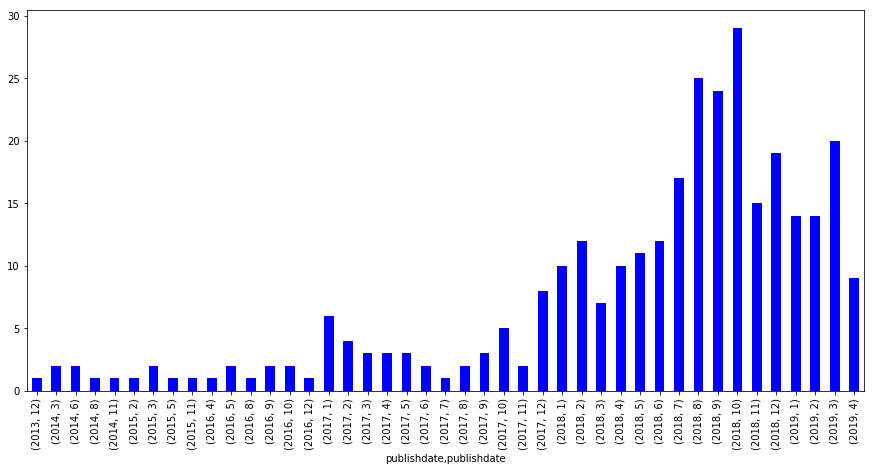

In [43]:
datacamp.groupby([datacamp['publishdate'].dt.year, datacamp['publishdate'].dt.month]).size().plot(kind='bar', figsize=(15,7), color='b')

### Since 2017 January

Since the duration from 2013 till 2016 represents very few posts, we will be ignoring them from now and considering posts starting Jan 2017. A filter will be applied for that as shown below

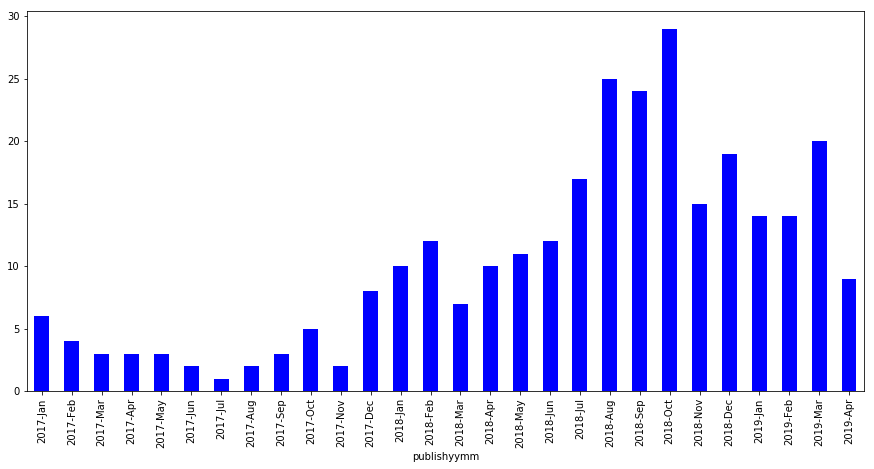

In [46]:
data[data["publishdate"]>='2017-01-01'] \
    .sort_values(by="publishdate", ascending=True) \
    .groupby([data['publishyymm']],sort=False) \
    .size() \
    .plot(kind='bar', figsize=(15,7), color='b')

Tutorials have paced up in 2018 with especially starting March onwards with a consistent upwards pace. Since this data was pulled in mid-August and almost crossing the middle line of July's tutorials count, we might be having August as the month with highest posts so far this year!

### Top Authors Graph

While we're pacing up on all these tutorials, who have been contributing on them along the way? Here we go with a simple bar chart highlighting this very fact.

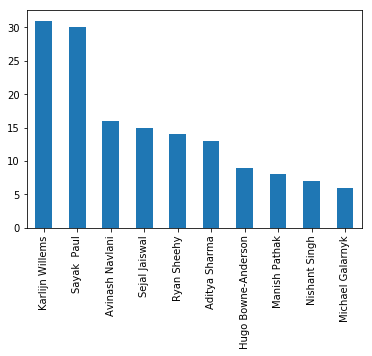

In [47]:
data[data["publishdate"]>='2017-01-01']["author"] \
    .value_counts(sort=True, ascending=False)[:10] \
    .plot(kind='bar')

### Top Authors List

Let's build a list of these as well while we are at it. We'll be using this soon below:

In [56]:
topauthors = data[data["publishdate"]>='2017-01-01']["author"] \
    .value_counts(sort=True, ascending=False)[:10] \
    .index

This is what happened in the code section above.

* Limited Result set to Tutorials since 2017 January
* Select only Author field
* Aggregated results using the value_counts function
* Sorted the result set in descending order and limited it to the first 10 rows

### Tutorials Paced over Timeline

Now what we're going to focus on is since when and at what pace have these top 10 contributors been posting tutorials. For this, we will be using the list we just created along with some transformations to come up with a stacked bar chart that we need.

In [71]:
dh = data[data["publishdate"]>='2017-01-01'] \
    .sort_values(by="publishdate", ascending=True) \
#     .set_index(["publishdate"])

In [72]:
dh.head()

,author,publishdate,title,description,upvote,publishyymm,posts
289,Karlijn Willems,2017-01-10,15 Easy Solutions To Your Data Frame Problems ...,"Discover how to create a data frame in R, chan...",49,2017-Jan,1
288,Ted Kwartler,2017-01-12,Web Scraping and Parsing Data in R | Explorin...,"Learn how to scrape data from the web, preproc...",14,2017-Jan,1
287,Ted Kwartler,2017-01-19,Exploring H-1B Data with R: Part 2,Learn even more about exploratory data analysi...,4,2017-Jan,1
286,Ted Kwartler,2017-01-26,Exploring H-1B Data with R: Part 3,Learn how to geocode locations and map them wi...,6,2017-Jan,1
285,Yao-Jen Kuo,2017-01-27,Scikit-Learn 教學：Python 與機器學習,簡單易懂的 scikit-learn 教學，適合想要使用 Python 實作機器學習的初學者閱讀。,36,2017-Jan,1


In [73]:
dh["publishdateone"] = pd.to_datetime(dh.publishdate.astype(str).str[0:7]+'-01')

This is what happened in the code section above.

* Limited Result set to Tutorials since 2017 January
* Sorted by Publish Date
* Making Publish Date as the Index column

Now that we're going to visualize using a stacked bar chart, the data set will now be pivoted by having the date field as the Index, Posts as values which are to be aggregated, and Authors as columns.

In [74]:
dhp = dh[dh["author"].isin(topauthors)] \
    .pivot_table(index="publishdateone",values="posts",columns="author", aggfunc=np.sum)

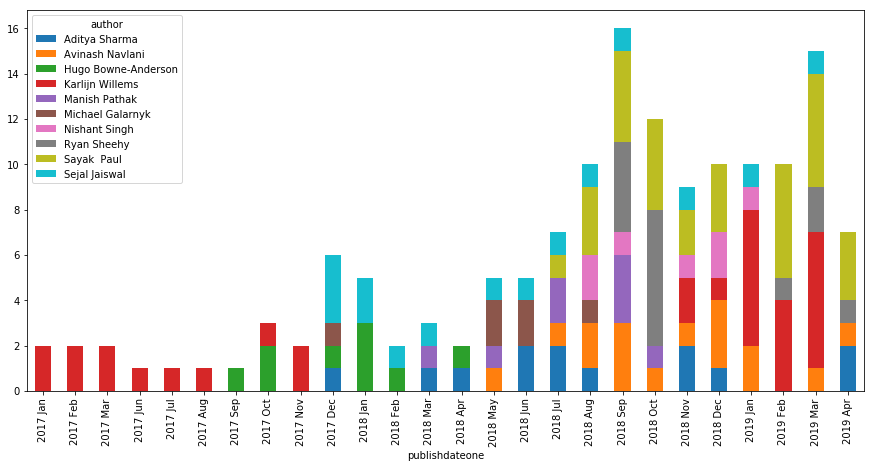

In [75]:
fig, ax = plt.subplots(figsize=(15,7))
dhp.plot(ax=ax, kind='bar', stacked=True)
ticklabels = [item.strftime('%Y %b') for item in dhp.index]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))

Here is what we possibly get out of the above Chart along with considering the earlier visualization of Tutorial Counts by Authors.

### Looking at Upvotes vs. Tutorials

When a reader likes a tutorial, an upvote is signaled respectively.

Let's see who's managed to get a good amount of upvotes vs. number of tutorials they have posted! We'll be considering the top 10 contributors in this case as well. This will be done by using a scatter plot.

In [76]:
upvotes = dh[dh["author"].isin(topauthors)] \
            .groupby(['author'], as_index=False) \
            .agg({'posts':"sum", 'upvote': "sum"})

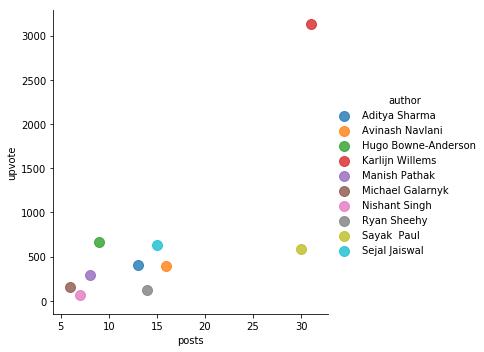

In [77]:
sns.lmplot('posts',
           'upvote',
           data=upvotes,
           fit_reg=False,
           hue="author",
           scatter_kws={"marker": "D", "s": 100})

## Conclusion

In this tutorial, we have managed to achieve the following:

* Scrape tutorials list across all pages
* Create a Data Frame and save it as CSV for later reference and Analysis
* Explored it using Pandas and Matplotlib along with some transformations
* Used Line, Bar, Stacked Bar and Scatter Plots to visualize